In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

In [2]:
def System(r,t,mu=1.5):

    x,vx = r

    dxdt = vx
    dvxdt = mu*(1-x**2)*vx - x

    return np.array([dxdt,dvxdt])

In [3]:
mu=1.5
def RungeKutta(f, r, t, h):
    k1 = h * f(r, t,mu)
    k2 = h * f(r + 0.5 * k1,t,mu)
    k3 = h * f(r + 0.5 * k2,t,mu)
    k4 = h * f(r + k3, t ,mu)
    return (k1 + 2 * k2 + 2 * k3 + k4) / 6
def IntegratorAdams(f,r0,t,mu):
    #difine el paso
    h = t[1] - t[0]
    #______________________________________
    x = np.zeros_like(t)
    vx = np.zeros_like(t)
    
    
    #CONDICIONES INICIALES
    x[0] = r0[0]
    vx[0] = r0[1]
    
    
    #runge khuta
    for i in range(1,5):
        present = np.array([x[i-1],vx[i-1]])
        p = RungeKutta(f,present,t[0],h)
        x[i] = x[i-1] + p[0]
        vx[i] = vx[i-1] + p[1]
        
    #CORRECCIONES
    xc = x.copy()
    vxc = vx.copy()


    K11 = np.zeros(2)
    K12 = np.zeros(2)
    K13 = np.zeros(2)
    K14 = np.zeros(2)
    
    
    for i in range(5,len(t)):
        
        present = np.array([x[i-1],vx[i-1]])
        past_1 = np.array([x[i-2],vx[i-2]])
        past_2 = np.array([x[i-3],vx[i-3]])
        past_3 = np.array([x[i-4],vx[i-4]])
        
        #FUNCIONES EVALUADAS EN CADA PASO
        K11 = f(present,t[i-1],mu)
        K12 = f(past_1,t[i-2],mu)
        K13 = f(past_2,t[i-3],mu)
        K14 = f(past_3,t[i-4],mu)
        
        #ADAMS
        x[i] =   x[i-1] + h*((55/24)*K11[0]-(59/24)*K12[0]+(37/24)*K13[0]-(3/8)*K14[0])
        vx[i] = vx[i-1] + h*((55/24)*K11[1]-(59/24)*K12[1]+(37/24)*K13[1]-(3/8)*K14[1])
        
        xc[i] = x[i]
        vxc[i] = vx[i]
        
        # Futuro-MULTON
        futuro = np.array([x[i],vx[i]])
        Kmulton = f(futuro,t[i],mu)
        
        xc[i] =  xc[i-1] +  h*((251)*Kmulton[0]+(646)*K11[0]-(264)*K12[0]+(106)*K13[0]-(19)*K14[0])/720
        vxc[i] = vxc[i-1] + h*((251)*Kmulton[1]+(646)*K11[1]-(264)*K12[1]+(106)*K13[1]-(19)*K14[1])/720
    return x,vx,xc,vxc

In [4]:
t = np.linspace(0,20,10000)
r0 = [0.5,0.]
sol = IntegratorAdams(System,r0,t,1.5)


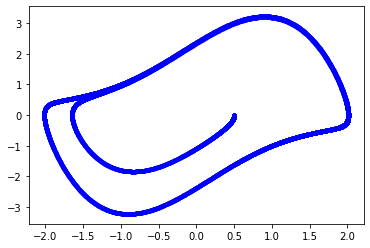

In [5]:
plt.scatter(sol[0],sol[1],marker='.',color='b')

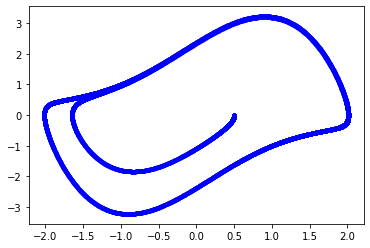

In [6]:
plt.scatter(sol[2],sol[3],marker='.',color='b')

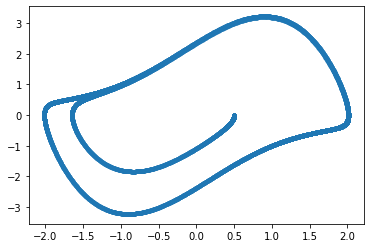

In [7]:
correcto = odeint(System, r0, t, args=(1.5,))
plt.scatter(correcto[:,0],correcto[:,1],marker='.')

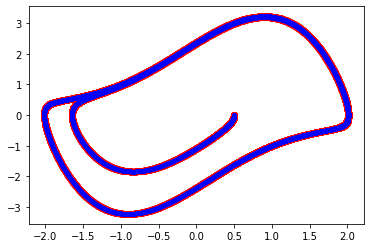

In [8]:
plt.scatter(correcto[:,0],correcto[:,1],marker='.')
plt.scatter(sol[2],sol[3],marker='o',color='r')
plt.scatter(sol[0],sol[1],marker='.',color='b')

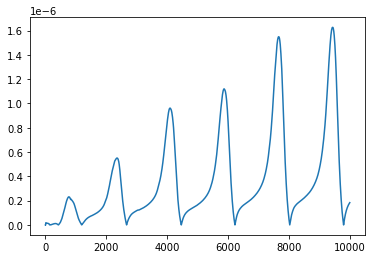

In [9]:
plt.plot(np.abs(sol[0]-correcto[:,0]))
max_mejorada = np.max(np.abs(sol[0]-correcto[:,0]))

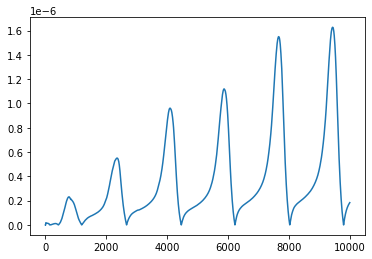

In [10]:
plt.plot(np.abs(sol[2]-correcto[:,0]))
max_mejorada = np.max(np.abs(sol[2]-correcto[:,0]))

ADAPTATIVO

In [13]:
#PASO CON RUNGE KUTA PARA CALCULAR DIFERENTES VARIACIONES EN EL PASO

def Increment(f,x,t,h): 

    
    k1 = f(x,t)
    k2 = f(x+0.5*h*k1,t+0.5*h)
    k3 = f(x+0.5*h*k2,t+0.5*h)
    k4 = f(x+h*k3, t+h)
    
    Deltaf = h*(k1+2*k2+2*k3+k4)/6
    
    return x+Deltaf

In [12]:
def CheckStep(Delta1,Delta2,Delta3,h,minimo=1e-2,maximo=1e-1):
    
    tolerancia = 0.001
    
    Delta1 = np.abs(Delta1)
    Delta2 = np.abs(Delta2)
    Delta3 = np.abs(Delta3)
    
    if Delta1 < tolerancia:
        h = minimo
        dx = Delta1
        
    else:
        
        if np.abs((Delta1 - Delta2))/Delta1 > maximo:
            h = 0.5*h
            dx = Delta2
        
        elif np.abs((Delta1-Delta3))/Delta1 < minimo:
            h = 2*h
            dx = Delta3
        
        else:
            dx = Delta1
            
    return dx,h

In [14]:

def Adaptativo(f,x0,t):

    
    h = t[1] - t[0]
    
    tf = t[-1]
    t = t[0]
    
    x = x0
    
    Time = np.array([t])
    Vector = np.array([x])
    Steps = np.array([h])
    
    while t < tf:
        
        Delta1 = Increment(f,x,t,h)
        Delta2 = Increment(f,x,t,0.5*h)
        Delta3 = Increment(f,x,t,2*h)
    
        dx,h = CheckStep(Delta1,Delta2,Delta3,h)
        
        x = Increment(f,x,t,h)
        t += h
        
        Steps = np.append(Steps,h )
        Time = np.append(Time,t)
        Vector = np.append(Vector,x)
        
    return Time,Vector,Steps

In [30]:
#VECTORIZADO
def System(r,t,mu=1.5):
    
    x,vx = r
    
    dxdt = vx
    dvxdt = mu*(1-x**2)*vx - x
    
    return np.array([dxdt,dvxdt])

def Increment(f,r,t,h):
    
    state1 = np.array([r[0],r[1]])
    K1 = f(state1,t)
    
    state2 = np.array([r[0]+0.5*h*K1[0],r[1]+0.5*h*K1[1]])
    K2 = f(state2,t+0.5*h)
    
    state3 = np.array([r[0]+0.5*h*K2[0],r[1]+0.5*h*K2[1]])
    K3 = f(state3,t+0.5*h)
    
    state4 = np.array([r[0]+h*K3[0],r[1]+h*K3[1]])
    K4 = f(state4, t+h)
    
    Deltaf = h*(K1+2*K2+2*K3+K4)/6
    
    return r+Deltaf
def CheckStep(Delta1,Delta2,Delta3,h,minimo=1e-2,maximo=1e-1):
    
    tolerancia = 0.001
    
    Delta1 = np.abs(Delta1)
    Delta2 = np.abs(Delta2)
    Delta3 = np.abs(Delta3)
    
    if Delta1 < tolerancia:
        h = minimo
        dx = Delta1
        
    else:
        
        if np.abs((Delta1 - Delta2))/Delta1 > maximo:
            h = 0.5*h
            dx = Delta2
        
        elif np.abs((Delta1-Delta3))/Delta1 < minimo:
            h = 2*h
            dx = Delta3
        
        else:
            dx = Delta1
            
    return dx,h
def Adaptativo(f,x0,t):
    
    h = t[1] - t[0]
    
    tf = t[-1]
    t = t[0]
    
    r = r0
    
    Time = np.array([t])
    Vector = r
    
    Steps = np.array([h])
    
    while t < tf:
        
        Delta1 = Increment(f,r,t,h)
        Delta2 = Increment(f,r,t,0.5*h)
        Delta3 = Increment(f,r,t,2*h)
   
        Deltas = Delta1.copy()
        ht = Delta1.copy()
        
        for i in range(Delta1.shape[0]):
            Deltas[i],ht[i] = CheckStep(Delta1[i],Delta2[i],Delta3[i],h)
    
    
        h = np.mean(ht)
        t += h
        
        r = Increment(f,r,t,h)
        
        
        Steps = np.append(Steps,h )
        Time = np.append(Time,t)
        Vector = np.vstack((Vector,r))
        
    return Time,Vector,Steps

In [31]:
t = np.linspace(0,20,100)
r0 = np.array([0.5,0.])
t1,x1,h1 = Adaptativo(System,r0,t)

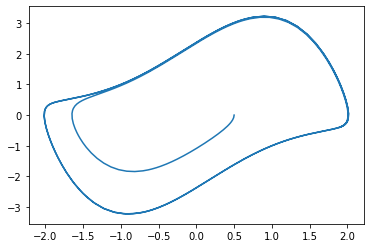

In [32]:
plt.plot(x1[:,0],x1[:,1])